$$-\Delta u = 10$$ for $(x,y) \in \Omega \subset \mathbb{R}^{2}$ and $u = 0$ on $\partial \Omega.$ 
Where $$\Omega = (-1,1)^2 \setminus (0,1) \times (-1,0)$$ in a "L"-shape domain with coordinates and elements as shown in the picture below:

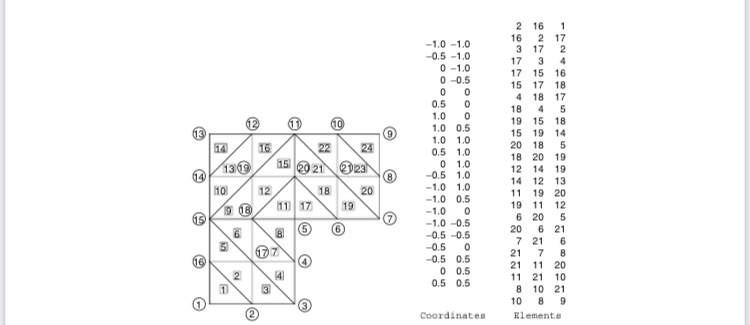

In [15]:
from IPython.display import Image
Image(filename ="/Users/nikosmatsavelas/Desktop/IMG_8369.jpg")

In [16]:
import dmsh
import numpy as np
from skfem import *
from skfem.models.poisson import laplace, unit_load
from skfem import LinearForm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 18})

@LinearForm
def f(x, y):
    return(10.0)


coordinates = np.array([
        [-1.0, -1.0],
        [-0.5, -1.0],
        [ 0.0, -1.0],
        [ 0.0, -0.5],
        [ 0.0,  0.0],
        [ 0.5,  0.0],
        [ 1.0,  0.0],
        [ 1.0,  0.5],
        [ 1.0,  1.0],
        [ 0.5,  1.0],
        [ 0.0,  1.0],
        [-0.5,  1.0],
        [-1.0,  1.0],
        [-1.0,  0.5],
        [-1.0,  0.0],
        [-1.0, -0.5],
        [-0.5, -0.5],
        [-0.5,  0.0],
        [-0.5,  0.5],
        [ 0.0,  0.5],
        [ 0.5,  0.5]]);print(coordinates)


elements = np.array([[2,  16, 1], 
                     [16,  2,17],
                     [3,  17, 2],
                     [17,  3, 4],
                     [17, 15,16],
                     [15, 17,18],
                     [4,  18,17],
                     [18,  4, 5],
                     [19, 15,18], 
                     [15, 19,14],
                     [20, 18, 5],
                     [18, 20,19],
                     [12, 14,19], 
                     [14, 12,13],
                     [11, 19,20],
                     [19, 11,12],
                     [6,  20, 5],
                     [20,  6,21],
                     [7,  21, 6],
                     [21,  7, 8],
                     [21, 11,20],
                     [11, 21,10],
                     [8,  10,21],
                     [10,  8, 9]]);print(elements)

[[-1.  -1. ]
 [-0.5 -1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.5  0. ]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]
 [ 0.5  1. ]
 [ 0.   1. ]
 [-0.5  1. ]
 [-1.   1. ]
 [-1.   0.5]
 [-1.   0. ]
 [-1.  -0.5]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [ 0.   0.5]
 [ 0.5  0.5]]
[[ 2 16  1]
 [16  2 17]
 [ 3 17  2]
 [17  3  4]
 [17 15 16]
 [15 17 18]
 [ 4 18 17]
 [18  4  5]
 [19 15 18]
 [15 19 14]
 [20 18  5]
 [18 20 19]
 [12 14 19]
 [14 12 13]
 [11 19 20]
 [19 11 12]
 [ 6 20  5]
 [20  6 21]
 [ 7 21  6]
 [21  7  8]
 [21 11 20]
 [11 21 10]
 [ 8 10 21]
 [10  8  9]]


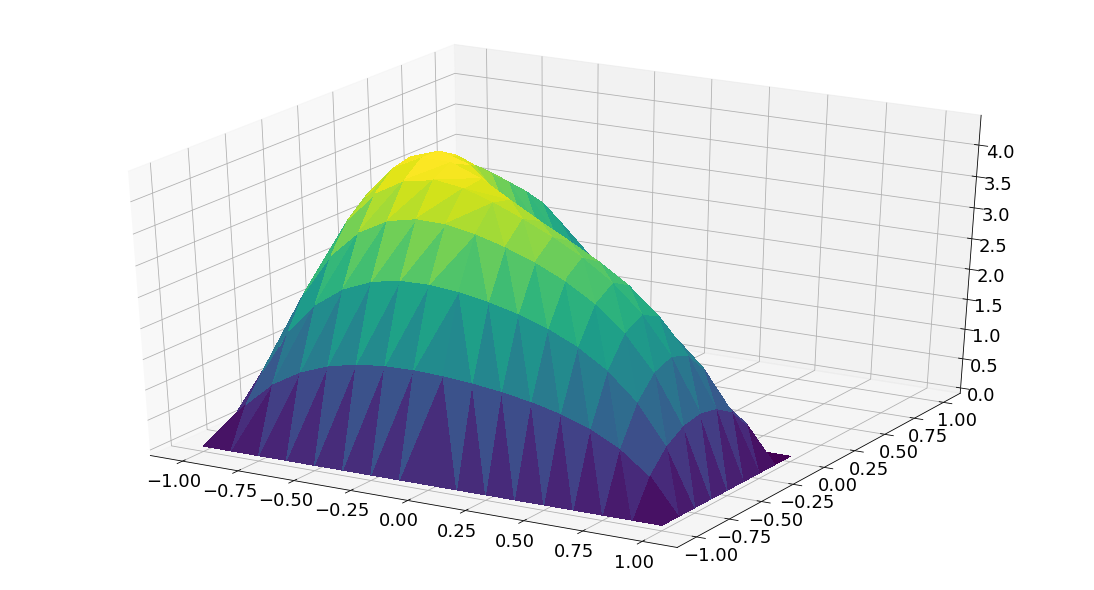

In [14]:
import numpy as np
from skfem import *
from skfem.models.poisson import laplace, unit_load
from skfem import LinearForm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 18})

@LinearForm
def f(x, y):
    return 10.0

m = MeshTri.init_lshaped()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(f, basis)

x = solve(*condense(A, b, I=m.interior_nodes()))

if __name__ == "__main__":
    from os.path import splitext
    from sys import argv
    from skfem.visuals.matplotlib import plot3, show
    plot3(m, x)
    show()

$$u_{t}-\Delta u = 10$$ for $$(t,x,y) \in (0,1) \times \Omega \subset \mathbb{R}^{2}$$ and $u = 0$ on $(0,1) \times \partial \Omega.$ 


Where:

$$\Omega = (-1,1)^2 \setminus (0,1) \times (-1,0)$$ in a "L"-shape domain same as the previous problem.